In [1]:
import pyspark.sql.functions as f
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark import SparkContext
from pyspark.sql import SQLContext

In [2]:
# sc = SparkContext(appName="umsi618f22lab7")
sqlc = SQLContext(sc)

# load datasets
dhds = sqlContext.read.csv("Disability_and_Health_Data_System__DHDS.csv", header=True)
dhds.printSchema()

brfss = sqlContext.read.csv("Behavioral_Risk_Factor_Surveillance_System__BRFSS__-__National_Cardiovascular_Disease_Surveillance_Data.csv", header=True)
brfss.printSchema()

/sw/pkgs/arc/spark/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


root
 |-- Rowid: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- LocationAbbr: string (nullable = true)
 |-- LocationDesc: string (nullable = true)
 |-- DataSource: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Indicator: string (nullable = true)
 |-- Response: string (nullable = true)
 |-- Data_Value_Unit: string (nullable = true)
 |-- Data_Value_Type: string (nullable = true)
 |-- Data_Value: string (nullable = true)
 |-- Data_Value_Alt: string (nullable = true)
 |-- Data_Value_Footnote_Symbol: string (nullable = true)
 |-- Data_Value_Footnote: string (nullable = true)
 |-- Low_Confidence_Limit: string (nullable = true)
 |-- High_Confidence_Limit: string (nullable = true)
 |-- Number: string (nullable = true)
 |-- WeightedNumber: string (nullable = true)
 |-- StratificationCategory1: string (nullable = true)
 |-- Stratification1: string (nullable = true)
 |-- StratificationCategory2: string (nullable = true)
 |-- Stratification2: string (null

In [3]:
#Register as temp tables
dhds.registerTempTable('dhds')
# dhds.show()

brfss.registerTempTable('brfss')
# brfss.show()

/sw/pkgs/arc/spark/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(
22/10/27 13:35:29 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
#Checking the unique values of years in both datasets to join appropriately
test1 = sqlc.sql('''SELECT DISTINCT Year FROM dhds ORDER BY Year''')
# q1.registerTempTable("q1")
test1.show()

test2 = sqlc.sql('''SELECT DISTINCT Year FROM brfss ORDER BY Year''')
# q1.registerTempTable("q1")
test2.show()

+----+
|Year|
+----+
|2016|
|2017|
|2018|
|2019|
|2020|
+----+

+----+
|Year|
+----+
|2011|
|2012|
|2013|
|2014|
|2015|
|2016|
|2017|
|2018|
+----+



### Task 1:
Determine the trend of risk and prevalence percentages experienced by individuals with hearing disability who are at some kind of risk (Hypertension, diabetes,etc.)

In [5]:
q11 = sqlc.sql('''SELECT Year, LocationDesc,Stratification1, AVG(Data_Value) AS Prevalence_percentage
                FROM dhds 
                WHERE Year IN (2016,2017,2018) 
                GROUP BY Year, LocationDesc, Stratification1
    ''')
q11.registerTempTable("q11")
q11.show()

+----+--------------------+--------------------+---------------------+
|Year|        LocationDesc|     Stratification1|Prevalence_percentage|
+----+--------------------+--------------------+---------------------+
|2016|        HHS Region 6|Independent Livin...|    17.97142857142857|
|2016|        HHS Region 4|      Any Disability|   43.580974842767326|
|2016|              Alaska|  Hearing Disability|   43.138709677419364|
|2016|                Guam| Mobility Disability|     41.5418918918919|
|2016|        HHS Region 8| Mobility Disability|    36.32499999999999|
|2016|              Kansas|             Overall|               17.125|
|2016|             Arizona|  Hearing Disability|     36.5862068965517|
|2016|District of Columbia|Self-care Disability|   19.889473684210525|
|2016|             Alabama| Mobility Disability|    38.43932584269663|
|2016|             Georgia|Self-care Disability|    17.79090909090909|
|2016|        HHS Region 3|Self-care Disability|   16.311111111111114|
|2016|

In [6]:
q12 = sqlc.sql('''SELECT Year, LocationDesc,Topic, 
    COALESCE(Data_Value, AVG(Data_Value) OVER (PARTITION BY Year, LocationDesc)) AS risk_data_value_imputed  
                FROM brfss 
                WHERE Year IN (2016,2017,2018) AND LocationDesc != "Median of all states" AND Category = "Risk Factors"
    ''')
q12.registerTempTable("q12")
q12.show()

+----+------------+--------------------+-----------------------+
|Year|LocationDesc|               Topic|risk_data_value_imputed|
+----+------------+--------------------+-----------------------+
|2016|     Alabama|Cholesterol Abnor...|     33.456521739130444|
|2016|     Alabama|Cholesterol Abnor...|     33.456521739130444|
|2016|     Alabama|Cholesterol Abnor...|     33.456521739130444|
|2016|     Alabama|Cholesterol Abnor...|     33.456521739130444|
|2016|     Alabama|Cholesterol Abnor...|     33.456521739130444|
|2016|     Alabama|Cholesterol Abnor...|     33.456521739130444|
|2016|     Alabama|Cholesterol Abnor...|     33.456521739130444|
|2016|     Alabama|Cholesterol Abnor...|     33.456521739130444|
|2016|     Alabama|Cholesterol Abnor...|     33.456521739130444|
|2016|     Alabama|Cholesterol Abnor...|     33.456521739130444|
|2016|     Alabama|Cholesterol Abnor...|     33.456521739130444|
|2016|     Alabama|Cholesterol Abnor...|     33.456521739130444|
|2016|     Alabama|Choles

In [7]:
q14 = sqlc.sql('''SELECT Year, LocationDesc,Topic, AVG(risk_data_value_imputed) AS Risk_percentage 
                FROM q12 
                GROUP BY Year, LocationDesc, Topic
    ''')
q14.registerTempTable("q14")
q14.show()


+----+------------+--------------------+------------------+
|Year|LocationDesc|               Topic|   Risk_percentage|
+----+------------+--------------------+------------------+
|2016|     Alabama|Cholesterol Abnor...| 33.45652173913047|
|2016|     Alabama|            Diabetes| 20.27193675889328|
|2016|     Alabama|           Nutrition|33.456521739130444|
|2016|     Alabama|             Obesity| 32.59130434782609|
|2016|     Alabama| Physical Inactivity| 67.10403726708076|
|2016|     Alabama|             Smoking| 22.25807453416149|
|2016|     Alabama|        Hypertension| 33.45652173913047|
|2016|      Alaska|Cholesterol Abnor...| 33.55873015873019|
|2016|      Alaska|            Diabetes|17.055050505050506|
|2016|      Alaska|             Obesity| 32.32205215419501|
|2016|      Alaska|           Nutrition|33.558730158730164|
|2016|      Alaska|             Smoking| 23.77392290249433|
|2016|      Alaska| Physical Inactivity| 71.75124716553289|
|2016|      Alaska|        Hypertension|

In [8]:
q13 = sqlc.sql('''SELECT * FROM q11 JOIN q14 ON q11.Year = q14.Year AND q11.LocationDesc = q14.LocationDesc 
ORDER BY Risk_percentage DESC
    ''')
q13.registerTempTable("q13")
q13.show()

+----+------------+--------------------+---------------------+----+------------+-------------------+-----------------+
|Year|LocationDesc|     Stratification1|Prevalence_percentage|Year|LocationDesc|              Topic|  Risk_percentage|
+----+------------+--------------------+---------------------+----+------------+-------------------+-----------------+
|2016|    Colorado|Independent Livin...|   17.003703703703703|2016|    Colorado|Physical Inactivity|82.67857142857143|
|2016|    Colorado|             Overall|              16.3125|2016|    Colorado|Physical Inactivity|82.67857142857143|
|2016|    Colorado| Mobility Disability|    36.87777777777777|2016|    Colorado|Physical Inactivity|82.67857142857143|
|2016|    Colorado|  Hearing Disability|     37.1793103448276|2016|    Colorado|Physical Inactivity|82.67857142857143|
|2016|    Colorado|   Vision Disability|    36.72386363636365|2016|    Colorado|Physical Inactivity|82.67857142857143|
|2016|    Colorado|Cognitive Disability|    36.3

In [9]:
q15 = sqlc.sql('''SELECT Stratification1 AS Disability,Topic AS Type_of_Risk, AVG(Risk_percentage) AS Average_Risk_Percentage,
                AVG(Prevalence_percentage) AS Average_Prevalence_Percentage FROM q13 
                WHERE Stratification1 = "Hearing Disability"
                GROUP BY Disability,Topic ORDER BY Average_Risk_Percentage DESC, Average_Prevalence_Percentage DESC ''')
q15.registerTempTable("q15")
q15.show()

+------------------+--------------------+-----------------------+-----------------------------+
|        Disability|        Type_of_Risk|Average_Risk_Percentage|Average_Prevalence_Percentage|
+------------------+--------------------+-----------------------+-----------------------------+
|Hearing Disability| Physical Inactivity|       71.8653852974565|            38.50902116639243|
|Hearing Disability|        Hypertension|     40.504922077550134|            38.55425862273501|
|Hearing Disability|           Nutrition|        35.259569363937|            38.55425862273501|
|Hearing Disability|Cholesterol Abnor...|        35.259569363937|            38.55425862273501|
|Hearing Disability|             Obesity|     32.061893294826724|           38.509021166392415|
|Hearing Disability|             Smoking|     18.661986243230764|            38.50902116639243|
|Hearing Disability|            Diabetes|      16.45527157013463|            38.50902116639242|
+------------------+--------------------

In [10]:
import sys
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/sw/pkgs/arc/python/3.10.4/bin/python3.10 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/sw/pkgs/arc/python/3.10.4/bin/python3.10 -m pip install --upgrade pip' command.


### Task 2:
Calculate the male to female ratio based on aggregated risk percentages for each state in the United States such that it shows the gender distribution of the state whose individuals are at a comparatively higher risk (based on prevalence percentage) 

In [11]:
q31 = sqlc.sql('''SELECT Year, LocationDesc, StratificationCategory2 AS Demographics,
                    Stratification2 AS demographic_value, AVG(Data_Value) AS Prevalence_percentage
                FROM dhds
                WHERE StratificationCategory2 IS NOT NULL AND Stratification2 IS NOT NULL
                AND StratificationCategory2 = "Sex"
                GROUP BY Year, LocationDesc,StratificationCategory2, Stratification2
                ''')
q31.registerTempTable("q31")
q31.show()

+----+-------------+------------+-----------------+---------------------+
|Year| LocationDesc|Demographics|demographic_value|Prevalence_percentage|
+----+-------------+------------+-----------------+---------------------+
|2016|     Michigan|         Sex|           Female|    44.06779661016951|
|2016|     Missouri|         Sex|             Male|   44.787068965517236|
|2016|     Oklahoma|         Sex|           Female|   44.420512820512826|
|2016| North Dakota|         Sex|           Female|   44.432478632478634|
|2016|   New Mexico|         Sex|           Female|   44.067796610169495|
|2016|     Maryland|         Sex|             Male|   44.431623931623925|
|2016| Pennsylvania|         Sex|             Male|    44.43418803418805|
|2016| North Dakota|         Sex|             Male|     45.1686956521739|
|2016| South Dakota|         Sex|           Female|    45.30350877192982|
|2016|    Minnesota|         Sex|             Male|    44.43931623931624|
|2016|         Ohio|         Sex|     

In [12]:
q32 = sqlc.sql('''SELECT Year, LocationDesc, Break_Out_Category AS Demographics, Break_Out AS demographic_value
                    ,AVG(Data_Value) AS risk_percentage
                FROM brfss
                WHERE Break_Out_Category IS NOT NULL AND Break_Out IS NOT NULL AND Break_Out_Category = "Gender"
                AND Category = "Risk Factors" AND LocationDesc != "Median of all states"
                GROUP BY Year, LocationDesc,Break_Out_Category, Break_Out
                ''')
q32.registerTempTable("q32")
q32.show()

+----+-------------+------------+-----------------+------------------+
|Year| LocationDesc|Demographics|demographic_value|   risk_percentage|
+----+-------------+------------+-----------------+------------------+
|2013|         Iowa|      Gender|           Female|48.245000000000005|
|2016|       Kansas|      Gender|           Female|29.149999999999995|
|2016|       Nevada|      Gender|             Male|             28.75|
|2015|       Oregon|      Gender|             Male| 47.38000000000001|
|2013|     Virginia|      Gender|           Female|48.285000000000004|
|2012|     Michigan|      Gender|           Female|35.089999999999996|
|2012|New Hampshire|      Gender|             Male|33.970000000000006|
|2018|      Wyoming|      Gender|           Female|             34.55|
|2012|     Missouri|      Gender|             Male|             34.45|
|2012|        Texas|      Gender|           Female|32.470000000000006|
|2011|         Iowa|      Gender|           Female|             48.27|
|2017|

In [13]:
q33 = sqlc.sql('''SELECT a.Year, a.LocationDesc, a.Demographics, a.demographic_value,a.Prevalence_percentage,
                 b.risk_percentage
                FROM q31 AS a JOIN q32 AS b
                ON a.Year = b.Year AND
                a.LocationDesc = b.LocationDesc AND
                a.demographic_value = b.demographic_value
                ''')
q33.registerTempTable("q33")
q33.show()

+----+------------+------------+-----------------+---------------------+------------------+
|Year|LocationDesc|Demographics|demographic_value|Prevalence_percentage|   risk_percentage|
+----+------------+------------+-----------------+---------------------+------------------+
|2017|  Washington|         Sex|             Male|    43.18159999999999|35.760000000000005|
|2016|  California|         Sex|           Female|   44.066949152542385|28.600000000000005|
|2017|     Georgia|         Sex|             Male|    42.85714285714285|             36.88|
|2018|    Oklahoma|         Sex|             Male|    44.23451327433628|33.459999999999994|
|2017|   Louisiana|         Sex|           Female|    42.85873015873016|             40.93|
|2018|North Dakota|         Sex|           Female|   44.535714285714285| 34.71999999999999|
|2016|    Delaware|         Sex|             Male|    44.76896551724138|28.849999999999998|
|2016|        Iowa|         Sex|           Female|   44.437606837606836|        

In [14]:
q34 = sqlc.sql('''SELECT LocationDesc, 
SUM(CASE WHEN demographic_value = "Male" THEN risk_percentage ELSE 0 END)/
SUM(CASE WHEN demographic_value = "Female" THEN risk_percentage ELSE 0 END) AS risk_male_female_ratio,
AVG(CASE WHEN demographic_value = "Male" THEN Prevalence_percentage ELSE 0 END) AS avg_prevalence_male,
AVG(CASE WHEN demographic_value = "Female" THEN Prevalence_percentage ELSE 0 END) AS  avg_prevalence_female
                FROM q33 GROUP BY LocationDesc
                ORDER BY risk_male_female_ratio DESC
                ''')
q34.registerTempTable("q34")
q34.show()

+------------+----------------------+-------------------+---------------------+
|LocationDesc|risk_male_female_ratio|avg_prevalence_male|avg_prevalence_female|
+------------+----------------------+-------------------+---------------------+
|  New Mexico|    1.0255483086073467| 22.022501124392363|    21.85241522450193|
|     Arizona|    1.0112141910490366| 22.045694786535304|   21.913130625520008|
|    Kentucky|    1.0098324022346368|  22.22380030197049|     21.9709524140887|
|   Tennessee|    1.0085136573252924| 22.156916249536522|   21.860201057407448|
|     Indiana|    1.0078214111129218| 21.972422297859467|    21.85710099415664|
|     Alabama|     1.006185567010309| 22.095172121785026|   21.797874984070347|
|    Delaware|    1.0060328266657679| 22.150943177604745|    21.97091625948617|
|  California|     1.002424494319756| 21.852045911388643|   21.850540648230748|
|Rhode Island|    0.9977986995394202| 22.272955241356367|   22.143467681001912|
|       Maine|    0.9977334691061985| 22

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'New Mexico'),
  Text(1, 0, 'Arizona'),
  Text(2, 0, 'Kentucky'),
  Text(3, 0, 'Tennessee'),
  Text(4, 0, 'Indiana'),
  Text(5, 0, 'Alabama'),
  Text(6, 0, 'Delaware'),
  Text(7, 0, 'California'),
  Text(8, 0, 'Rhode Island'),
  Text(9, 0, 'Maine'),
  Text(10, 0, 'Michigan'),
  Text(11, 0, 'Hawaii'),
  Text(12, 0, 'Pennsylvania'),
  Text(13, 0, 'Illinois'),
  Text(14, 0, 'Florida'),
  Text(15, 0, 'Wisconsin'),
  Text(16, 0, 'New York'),
  Text(17, 0, 'Alaska'),
  Text(18, 0, 'Texas'),
  Text(19, 0, 'Louisiana'),
  Text(20, 0, 'West Virginia'),
  Text(21, 0, 'Ohio'),
  Text(22, 0, 'North Carolina'),
  Text(23, 0, 'Massachusetts'),
  Text(24, 0, 'Virginia'),
  Text(25, 0, 'New Jersey'),
  

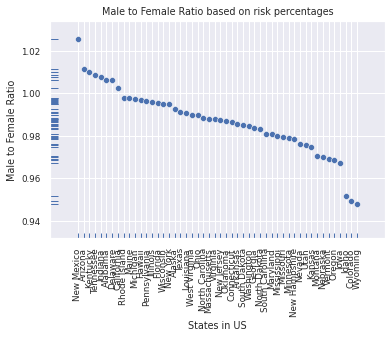

In [16]:
#A Scatterplot and rugplot representing the male to female ratio aggregated based on risk percentages for each state in the US

q35 = q34.toPandas()
sns.set(font_scale=0.8)
a = sns.scatterplot(data=q35, x="LocationDesc", y="risk_male_female_ratio").set(title="Male to Female Ratio based on risk percentages", xlabel='States in US', ylabel='Male to Female Ratio')
a = sns.rugplot(data=q35, x="LocationDesc", y="risk_male_female_ratio")
plt.xticks(rotation=90)




### Task 3:
Calculate the individual count for each indicator of a cardiovascular disease for people in Michigan between years 2016 to 2018 who have mobility disability

In [33]:
q41 = sqlc.sql('''SELECT Year, LocationDesc,Topic, 
    ROUND(COALESCE(Data_Value, AVG(Data_Value) OVER (PARTITION BY Year, LocationDesc)),2) AS Risk_Percentage  
                FROM brfss 
                WHERE Year IN (2016,2017,2018) AND LocationDesc != "Median of all states" AND Category = "Cardiovascular Diseases"
    ''')
q41.registerTempTable("q41")
q41.show()

+----+------------+--------------------+---------------+
|Year|LocationDesc|               Topic|Risk_Percentage|
+----+------------+--------------------+---------------+
|2016|     Alabama|Acute Myocardial ...|           8.54|
|2016|     Alabama|Acute Myocardial ...|            7.8|
|2016|     Alabama|Major Cardiovascu...|           13.7|
|2016|     Alabama|Acute Myocardial ...|           8.54|
|2016|     Alabama|Acute Myocardial ...|           8.54|
|2016|     Alabama|Acute Myocardial ...|            4.0|
|2016|     Alabama|Major Cardiovascu...|           13.5|
|2016|     Alabama|Acute Myocardial ...|            8.1|
|2016|     Alabama|Acute Myocardial ...|           8.54|
|2016|     Alabama|Acute Myocardial ...|            1.9|
|2016|     Alabama|Acute Myocardial ...|            5.1|
|2016|     Alabama|Acute Myocardial ...|           8.54|
|2016|     Alabama|Acute Myocardial ...|           8.54|
|2016|     Alabama|              Stroke|            4.0|
|2016|     Alabama|            

In [35]:
q42 = sqlc.sql('''SELECT Year, LocationDesc,Topic, ROUND(AVG(Risk_Percentage),2) AS Avg_Risk_percentage 
                FROM q41
                GROUP BY Year, LocationDesc, Topic
    ''')
q42.registerTempTable("q42")
q42.show()

+----+------------+--------------------+-------------------+
|Year|LocationDesc|               Topic|Avg_Risk_percentage|
+----+------------+--------------------+-------------------+
|2016|     Alabama|Acute Myocardial ...|               7.92|
|2016|     Alabama|Major Cardiovascu...|              13.02|
|2016|     Alabama|              Stroke|               6.34|
|2016|     Alabama|Coronary Heart Di...|               7.52|
|2016|      Alaska|Acute Myocardial ...|               5.14|
|2016|      Alaska|Major Cardiovascu...|               7.45|
|2016|      Alaska|              Stroke|               4.15|
|2016|      Alaska|Coronary Heart Di...|               5.04|
|2016|     Arizona|Acute Myocardial ...|               6.09|
|2016|     Arizona|Coronary Heart Di...|               5.45|
|2016|     Arizona|              Stroke|                4.6|
|2016|     Arizona|Major Cardiovascu...|               9.62|
|2016|    Arkansas|Acute Myocardial ...|               8.65|
|2016|    Arkansas|Major

In [36]:
q44 = sqlc.sql('''SELECT Year, LocationDesc as Location,Indicator,Stratification1,
                ROUND(AVG(WeightedNumber),2) as Avg_Individual_Count
                FROM dhds 
                GROUP BY Year, Location, Indicator, Stratification1
    ''')
q44.registerTempTable("q44")
q44.show()

+----+--------------------+--------------------+--------------------+--------------------+
|Year|            Location|           Indicator|     Stratification1|Avg_Individual_Count|
+----+--------------------+--------------------+--------------------+--------------------+
|2016|           Tennessee|Fair or poor self...|      Any Disability|           346311.89|
|2016|        South Dakota|Ever been tested ...|      Any Disability|            20208.64|
|2016|            Oklahoma|Ever had heart di...|      Any Disability|           186516.11|
|2016|        South Dakota|Income level amon...|       No Disability|             82851.6|
|2016|         Puerto Rico|Income level amon...|Cognitive Disability|             82867.0|
|2016|      South Carolina|Fair or poor self...|   Vision Disability|            115407.5|
|2016|       West Virginia|Fallen in the pas...|      Any Disability|           101124.19|
|2016| U.S. Virgin Islands|Employment status...|      Any Disability|             4788.67|

In [72]:
q43 = sqlc.sql('''SELECT a.Year, a.LocationDesc AS Location, a.Topic AS Type_of_Risk,
                a.Avg_Risk_Percentage,b.Indicator,b.Stratification1 AS Disability_Type, b.Avg_Individual_Count
                FROM q42 AS a JOIN q44 AS b ON a.Year = b.Year AND a.LocationDesc = b.Location 
                WHERE a.LocationDesc = "Michigan" AND b.Stratification1 = "Mobility Disability"
                ORDER BY b.Avg_Individual_Count DESC
    ''')
q43.registerTempTable("q43")
q43.show()

/sw/pkgs/arc/spark/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


+----+--------+--------------------+-------------------+--------------------+-------------------+--------------------+
|Year|Location|        Type_of_Risk|Avg_Risk_Percentage|           Indicator|    Disability_Type|Avg_Individual_Count|
+----+--------+--------------------+-------------------+--------------------+-------------------+--------------------+
|2017|Michigan|Major Cardiovascu...|              11.67|Disability status...|Mobility Disability|            618585.0|
|2017|Michigan|Acute Myocardial ...|               7.33|Disability status...|Mobility Disability|            618585.0|
|2017|Michigan|              Stroke|               5.56|Disability status...|Mobility Disability|            618585.0|
|2017|Michigan|Coronary Heart Di...|               7.12|Disability status...|Mobility Disability|            618585.0|
|2017|Michigan|Major Cardiovascu...|              11.67|Disability status...|Mobility Disability|            617439.5|
|2017|Michigan|Coronary Heart Di...|            

/home/iamsk/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40],
 [Text(0, 0, 'Disability status and types among adults 18 years of age or older by sex'),
  Text(1, 0, 'Disability status and types among adults 18 years of age or older by veteran status'),
  Text(2, 0, 'Could not see a doctor due to cost in the past 12 months among adults 18 years of age or older'),
  Text(3, 0, 'Ever had high blood pressure among adults 18 years of age or older'),
  Text(4, 0, 'Ever had diabetes among adults 18 years of age or older'),
  Text(5, 0, 'Fair or poor self-rated health among adults 18 years of age or older'),
  Text(6, 0, 'Ever had arthritis among adults 18 years of age or older'),
  Text(7, 0, 'Ever had a stroke among adults 18 years of age or older'),
  Text(8, 0, 'Health care coverage among adults 18 years of age or old

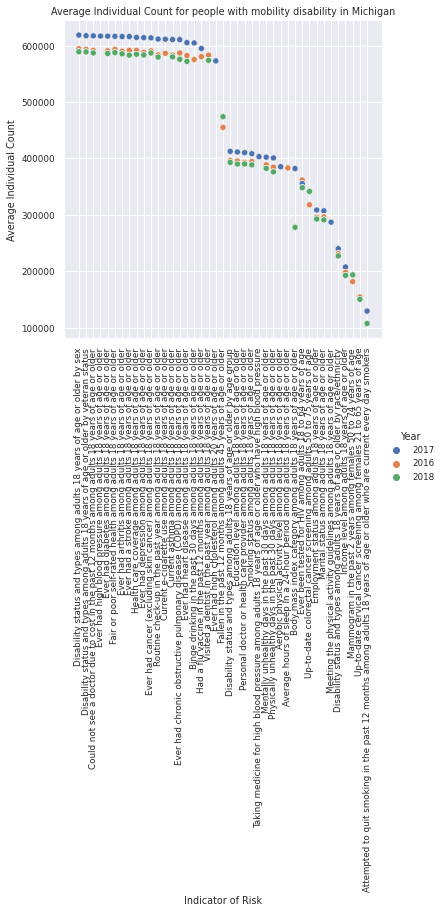

In [68]:
q44 = q43.toPandas()

sns.set(font_scale=0.8)
sns.relplot(data=q44, x="Indicator", y="Avg_Individual_Count", hue="Year").set(title="Average Individual Count for people with mobility disability in Michigan", xlabel="Indicator of Risk",ylabel="Average Individual Count")
plt.xticks(rotation=90)